# MASS FLOW CALCULATOR

-Adding Glass CE metric.


# Preamble and definitions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


In [3]:
def weibull_params(keypoints):
    '''Returns shape parameter `alpha` and scale parameter `beta`
    for a Weibull distribution whose CDF passes through the
    two time: value pairs in `keypoints`'''
    t1, t2 = tuple(keypoints.keys())
    cdf1, cdf2 = tuple(keypoints.values())
    alpha = np.asscalar(np.real_if_close(
        (np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j))/(np.log(t1) - np.log(t2))
    ))
    beta = np.abs(np.exp(
        (
            np.log(t2)*((0+1j)*np.pi + np.log(np.log(1 - cdf1)+0j))
            + np.log(t1)*(((0-1j))*np.pi - np.log(np.log(1 - cdf2)+0j))
        )/(
            np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j)
        )
    ))
    return {'alpha': alpha, 'beta': beta}

In [4]:
def weibull_cdf(alpha, beta):
    '''Return the CDF for a Weibull distribution having:
    shape parameter `alpha`
    scale parameter `beta`'''
    def cdf(x):
        return 1 - np.exp(-(np.array(x)/beta)**alpha)
    return cdf

# Waste projection

In [ ]:
# Dangerous assumptions (which need to be fixed or explained before publication) are marked with 'warning'

## Inputs

In [5]:
# The simulation is for this range of years
df = pd.DataFrame(index=np.arange(1995, 2024+1, 1))

### Installed capacity

In [6]:
# US annual installed capacity (watts)
# prior to 2010 is from Report IEA-PVPS T1-19:2010
# after 2010 is from Q4 2019 Wood Mackenzie Power & Renewables/SEIA U.S. Solar Market Insight
df['new_capacity_total'] = np.array([9.0, 9.7, 11.7, 11.9, 17.2, 21.5, 29.0, 44.4, 63.0, 100.8, 103.0, 145.0, 206.5, 338.0, 473.1, 849, 1921, 3373, 4766, 6244, 7501, 15152, 10845, 10790, 13352, 14904, 16456, 15227, 15224, 16634])*1e6

# that capacity includes non-crystalline-silicon, so needs to be derated by market share

# global market share numbers from 2018-2019 Photovoltaic Manufacturer Capacity, Shipments, Price & Revenues (SPV Market Research)
# warning: assuming that US market share is the same as the global market share
# warning: assuming, with a lack of data and to be conservative, that everything installed before 2008 was p-type mono-Si
# in the source, 'mono' includes n- and p-type
share_mono = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 35, 37, 38, 37, 36, 39, 35, 41, 45, 45, 59.85, 64.125, 68.4, 71.25, 74.1, 76.95])/100
# mono was 18% n-type in 2018
# warning: blindly extending this back to 2010, which is incorrect
share_ntype = share_mono*np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17.46031746, 19.84126984, 22.22222222, 25.21367521, 28.20512821, 31.1965812])/100
# warning: assuming that there was no multi before 2008
share_multi = np.array([ 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 49, 46, 48, 48, 52, 55, 55, 58, 54, 51, 51, 35.15, 30.875, 26.6, 23.75, 20.9, 18.05])/100

share_silicon = share_mono + share_multi

# here 'silicon' means 'crystalline silicon'
df['new_capacity_silicon'] = df['new_capacity_total']*share_silicon

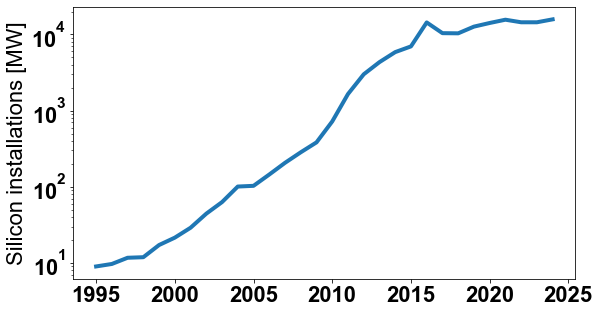

In [10]:
# Plotting Installed Capacity of Silicon

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')
pass

### PROJECTING CAPACITY

To project capacity into the future without economic, policy or behavior analysis:
assume cumulative capacity follows a logistic sigmoid function:
capacityscale/(1 + np.exp(-timescale * (-midtime + t)))
these parameters fit well:

capacityscale: 8.44466e10
timescale: 0.560261
midtime: 2016.45

his is kind of pessimistic, saying annual installations began slowing down permanently in 2016 and we'll only ever have a total of 84 GW installed in the US
Cutting off the last two years changes the parameters so we get >400 GW installed with a 2021 turning point

### Efficiency and area

In [11]:
# estimating efficiency
# global numbers from 2018-2019 Photovoltaic Manufacturer Capacity, Shipments, Price & Revenues (SPV Market Research)
# warning: these may be averaged across products available, not averaged across what was sold
# warning: prior to 2008 the numbers are based on linear extrapolations
efficiency_ntype = np.array([9.5, 10.1, 10.7, 11.2, 11.8, 12.4, 13, 13.6, 14.1, 14.7, 15.3, 15.9, 16.5, 17.45, 17.92, 18.04, 18.45, 19.2, 19.89, 20.2, 20.75, 21.2, 22.9, 23.2, 23.51, 23.82, 24.13, 24.44, 24.75, 25.06])/100
efficiency_mono = np.array([6.4, 6.9, 7.5, 8, 8.5, 9, 9.6, 10.1, 10.6, 11.1, 11.6, 12.2, 12.7, 13.45, 13.7, 14.1, 14.79, 15.1, 15.85, 16.5, 16.9, 17.3, 18.1, 18.4, 19.05, 19.7, 20.35, 21, 21.65, 22.3])/100
efficiency_multi = np.array([7.1, 7.5, 8, 8.4, 8.8, 9.3, 9.7, 10.1, 10.6, 11, 11.4, 11.9, 12.3, 13.01, 13.2, 13.7, 13.86, 14.5, 14.9, 15.1, 15.5, 16.2, 17.1, 17.2, 17.4, 17.6, 17.8, 18, 18.2, 18.4])/100
# weighted average efficiency
efficiency_aggregate = (
    ((share_mono - share_ntype)*efficiency_mono + share_ntype*efficiency_ntype + share_multi*efficiency_multi)/(share_mono + share_multi)
)
df['efficiency'] = efficiency_aggregate

# area of all PV installed each year (m^2)
irradiance_stc = 1000 # W/m^2
df['area'] = df['new_capacity_silicon']/df['efficiency']/irradiance_stc # m^2

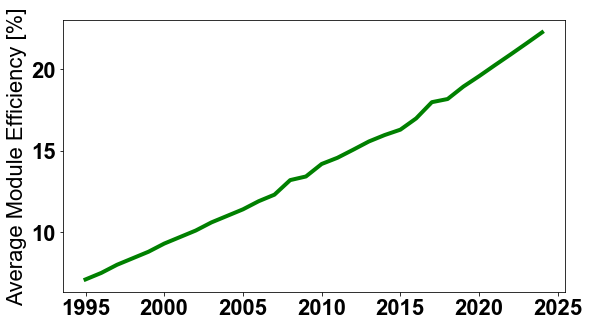

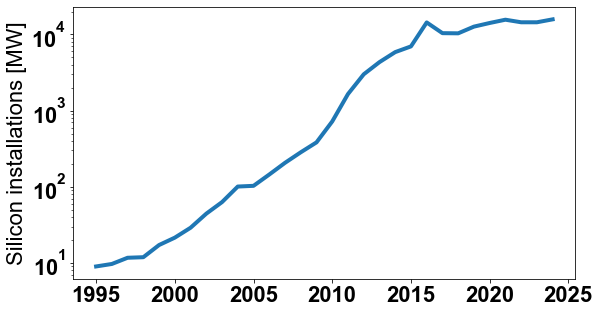

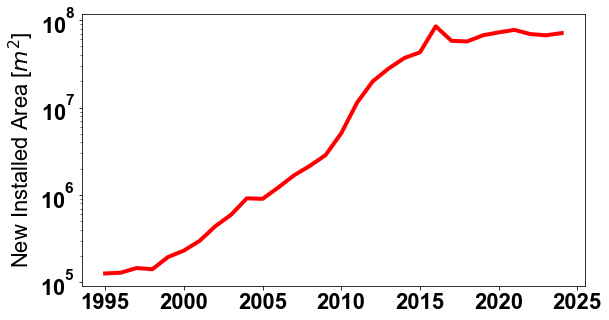

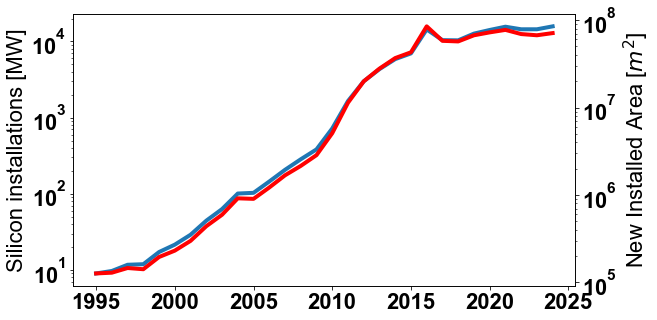

In [23]:
# Ploting Silicon Installations vs New Installed Area

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['efficiency']*100, 'g', linewidth=4)
plt.ylabel('Average Module Efficiency [%]')


fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['area'], 'r', linewidth=4)
plt.ylabel('New Installed Area [$m^2$]')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')

ax2=ax.twinx()
ax2.plot(df.index, df['area'], 'r', linewidth=4)
ax2.set_ylabel('New Installed Area [$m^2$]')
ax2.set_yscale('log')
plt.show()

pass

### Component mass

In [28]:
# mass of glass
# for now, assume that everything uses the equivalent of a single piece of glass of the same thickness
# warning: as of recently, this isn't true anymore and needs to be quantified (check ITRPV 2019 for future projections)
density_glass = 2500 # kg/m^3
thickness_glass = 3.5e-3 # m
print("Weight per m2 of glass ", thickness_glass*density_glass)
# in kg
df['mass_glass'] = df['area']*thickness_glass*density_glass

# mass of silver
# use past ITRPV predictions (read by eye from fig 65 in ITRPV 2019)
# warning: these aren't real data, they are industry predictions, but sometimes predictions for the current year
# warning: prior to 2009 these are extrapolations based on a linear fit
# in kg per cell
df['mass_silver_per_cell'] = np.array([0.85, 0.8, 0.8, 0.75, 0.7, 0.65, 0.65, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09, 0.08, 0.075, 0.06, 0.065, 0.05])/1000
# warning: assume cell efficiency equals module efficiency (not always true)
# warning: assume all cells are 156-mm squares (probably mostly true for 2010–2019, not super true outside of this)
area_cell = 0.156**2
df['n_cells'] = df['area']/area_cell
# in kg
df['mass_silver'] = df['mass_silver_per_cell']*df['n_cells']

# warning: need do the same thing for silicon, copper, etc.

Weight per m2 of glass  8.75


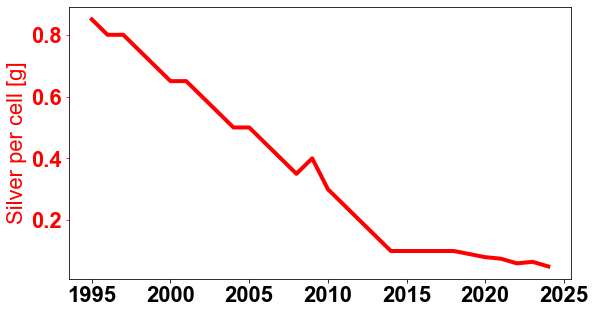

In [37]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_silver_per_cell']*1000, 'r', label='Silver', linewidth=4)
ax.set_ylabel('Silver per cell [g]', color='r')
ax.tick_params(axis='y', colors='r')


## Mass of GLASS
(Still in development)

In [ ]:
'''
# Based on ITRPV numbers. ITRPV 2014 sets thickness of glass to 3.5, so assuming that value for all previous modules since 1995.
# Starting 2015 ITRPV, transparent backside (glass + transparent sheet) starts at 2%. Assuming 50% is glass.and same front thickness.
# Starting 2017, front thicknesses are indicated for front side. Thinner modules coincide with the values for expected bifacial modules with glass-glass backside, so assuming all thiner modules have a backside of same thickness.
# Glass backside thickness is not specified, so assuming for glass-glass backside is 2 mm thick for all cases
#  where front side is between 2-3 mm (assuming 2 mm for front side), and 1.8mm for cases where front side is < 2 mmm ( assuming 1.8mm for front side as well)
#  So overall module per panel is 3.5 for single side glass to up 4 mm glass-glass
df['glass_3p5'] = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 93, 93])/100

df['glass_3p5'] = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 93, 93, 90])/100
df['glass_2p'] = np.array([0, 0, 0, 0, 0, 0 , 15, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100
df['glass_1p8'] = np.array([100, 100, 100, 100, 100, 100, 85, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100

df['glass_3p5'] = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 93, 93])/100
df['glass_2p5'] = np.array([np.nan, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, np.nan, 100, 100, 100, 100, 100, 100, 100, 93, np.nan])/100

# doesn't change the 1st one, last one is just repeated value.
df.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None)

import pandas as pd
from scipy.optimize import curve_fit

# Do the original interpolation
#df.interpolate(method='nearest', axis=0, inplace=True)

# Display result
print ('Interpolated data:')
print (df)
print ()

# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

# Create copy of data to remove NaNs for curve fitting
fit_df = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    df[col][x] = func(x, *col_params[col])

# Display result
print ('Extrapolated data:')
print (df)
print ()

print ('Data was extrapolated with these column functions:')
for col in col_params:
    print ('f_{}(x) = {:0.3e} x^3 + {:0.3e} x^2 + {:0.4f} x + {:0.4f}'.format(col, *col_params[col]))
   
   
# Mass of Silicon
# Fake numbers, just to establish process
df['cell_size_155'] = np.array([100, 100, 100, 100, 100, 100, 85, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100
df['cell_size_165'] = np.array([0, 0, 0, 0, 0, 0 , 15, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100

df['thickness_0p1'] = np.array([100, 100, 100, 100, 100, 100, 85, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100
df['thickness_0p2'] = np.array([0, 0, 0, 0, 0, 0 , 15, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.075, 0.05, 0.05])/100

area_cell_155 = 0.155**2
area_cell_165 = 0.165**2
df['area_cells_155'] = df['area']*df['cell_size_155']
df['area_cells_165'] = df['area']*df['cell_size_165']

df['VolumeSi_0p1_155'] = df['area_cells_155'] * df['thickness_0p1'] * 0.1
df['VolumeSi_0p1_165'] = df['area_cells_165'] * df['thickness_0p1'] * 0.1

df['VolumeSi_0p2_155'] = df['area_cells_155'] * df['thickness_0p2'] * 0.2
df['VolumeSi_0p2_165'] = df['area_cells_165'] * df['thickness_0p2'] * 0.2

silicon_density = 2532.59  # kg/m^3 Google knows best.
df['Mass_Silicon'] = silicon_density * (df['VolumeSi_0p1_155'] + df['VolumeSi_0p1_165'] + df['VolumeSi_0p2_155'] + df['VolumeSi_0p2_165'])

'''
print("")

## New Installed Material Plots

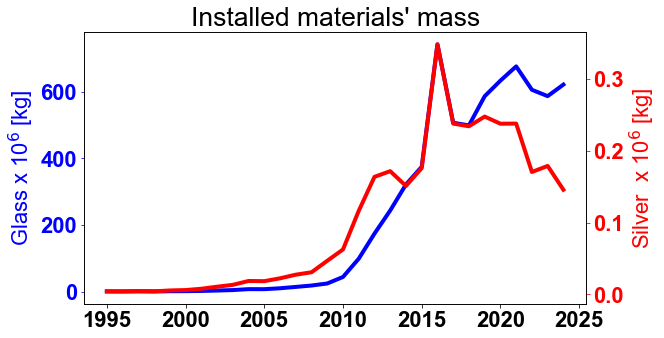

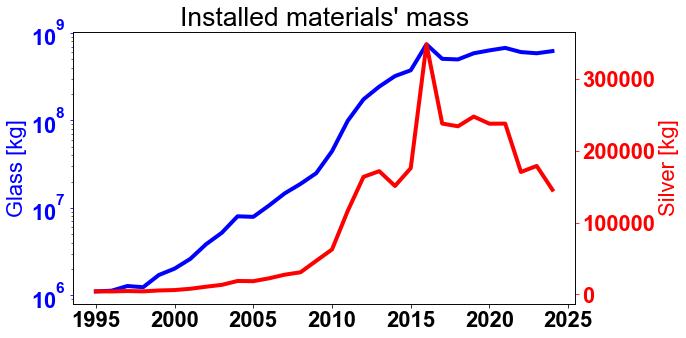

In [40]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_glass']/1000000, color='blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass x 10$^6$ [kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2=ax.twinx()
plt.title("Installed materials' mass")
ax2.plot(df.index, df['mass_silver']/1000000, 'r', label='Silver', linewidth=4)
ax2.set_ylabel('Silver  x 10$^6$ [kg]', color='red')
ax2.tick_params(axis='y', colors='red')


fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_glass'], color='blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass [kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax.set_yscale('log')
ax2=ax.twinx()
plt.title("Installed materials' mass")
ax2.plot(df.index, df['mass_silver'], 'r', label='Silver', linewidth=4)
ax2.set_ylabel('Silver [kg]', color='red')
ax2.tick_params(axis='y', colors='red')
ax.set_yscale('log')
pass



### Reliability

In [35]:
# warning: these are wild guesses
# T50: years until 90% of that year's cohort has been disposed
# T90: years until 99% of that year's cohort has been disposed
df['t50'] = [15, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 22, 23, 23, 24, 24, 25, 25, 25, 25, 25, 30, 30, 30]
df['t90'] = [20, 20, 21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 30, 30, 37.5, 37.5, 37.5, 37.5]

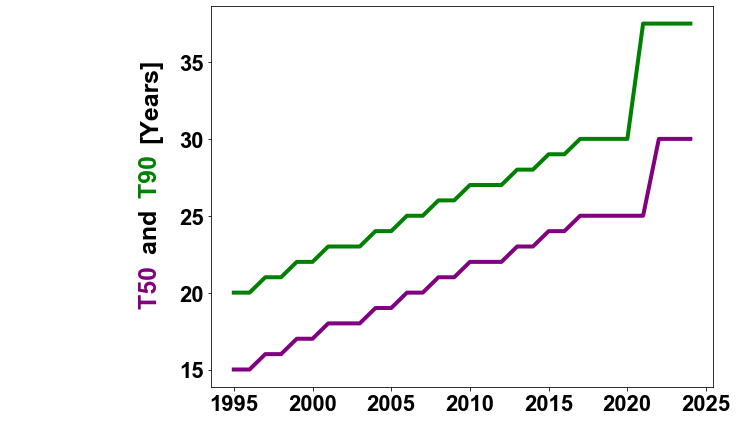

In [41]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

fig, ax = plt.subplots(figsize=(9, 7))
plt.plot(df.index, df['t50'], color='purple', label='t50', linewidth=4)
plt.plot(df.index, df['t90'], color='green', label='t90', linewidth=4)
#ax.set_ylabel('T50 (Median Time to Fail) and T90 [Years]')

ybox1 = TextArea("T50 ", textprops=dict(color="purple", size=25,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea("and ",     textprops=dict(color="black", size=25,rotation=90,ha='left',va='bottom'))
ybox3 = TextArea("T90 ", textprops=dict(color="green", size=25,rotation=90,ha='left',va='bottom'))
ybox4 = TextArea("[Years]",     textprops=dict(color="black", size=25,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox4, ybox3, ybox2, ybox1],align="bottom", pad=-155, sep=5)

anchored_ybox = AnchoredOffsetbox(loc=8, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.12, 0.6), 
                                  bbox_transform=ax.transAxes, borderpad=0.)

ax.add_artist(anchored_ybox)


pass


## Eliminating Modules through Weibull


### Calculating Weibull PArameters Example

In [50]:
test_t50 = 30
test_t90 = 25
test = weibull_params({test_t50: 0.50, test_t90: 0.90})
print("WEIBULL Parameters for a t50 and t90 of ", test_t50, " & ", test_t90, " years are Alpha: ", test['alpha'], " Beta: ", test['beta'])


WEIBULL Parameters for a t50 and t90 of  30  &  25  years are Alpha:  -6.584769167950776  Beta:  28.375800096802017


### Cumulative Distribution Function for each Generation

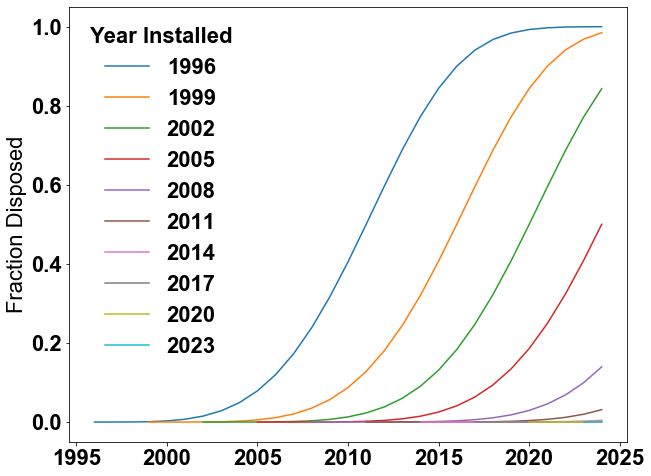

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
for year, row in df.iterrows():
    if year%3 != 1: # doing every 3 years to not have too much stuff.
        continue
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    ax.plot(x + year, y, label=year)
ax.legend(frameon=False, title='Year Installed')
ax.set_ylabel('Fraction Disposed')
pass

### Disposing of Modules with the Weibull paramaeters for each generation

In [54]:
df['disposal_function'] = [
    weibull_cdf(**weibull_params({t50: 0.5, t90: 0.9}))
    for t50, t90
    in zip(df['t50'], df['t90'])
]

In [79]:
df['year'] = df.index

for year, row in df.iterrows():
    print(year, row['year'])

df.index

1995 1995
1996 1996
1997 1997
1998 1998
1999 1999
2000 2000
2001 2001
2002 2002
2003 2003
2004 2004
2005 2005
2006 2006
2007 2007
2008 2008
2009 2009
2010 2010
2011 2011
2012 2012
2013 2013
2014 2014
2015 2015
2016 2016
2017 2017
2018 2018
2019 2019
2020 2020
2021 2021
2022 2022
2023 2023
2024 2024


In [97]:
#foo.diff().fillna(0)

res = [j - i for i, j in zip(foo[: -1], foo[1 :])] 
res

[8.566397607490117e-06,
 0.0001459643872571137,
 0.0006843970156866774,
 0.0019452167309753632,
 0.004265761768045939,
 0.007977070554540444,
 0.013371468254351426,
 0.02065498317058123,
 0.029883562452050483,
 0.04088775916731602,
 0.053198823627098046,
 0.06599902726428708,
 0.07812740790051986,
 0.08817326822761662,
 0.09467672308206598,
 0.09642383242246555,
 0.09277707460661855,
 0.08393697121921984,
 0.07101585146745892,
 0.05584627028423739,
 0.04054606396150173,
 0.026979986042774406,
 0.016324876743446626,
 0.008906587437021107,
 0.004342414476781298,
 0.0018740737458314838,
 0.000708809423981438,
 0.00023248178629398097,
 6.539928024584807e-05]

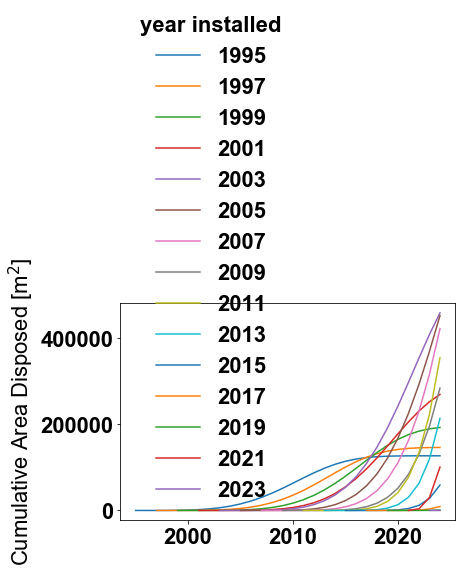

In [127]:
df['cdf_weibull'] = 0
fig, ax = plt.subplots()
for year, row in df.iterrows():
    if year%2 != 1:
        continue
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    ax.plot(x + year, np.array(y)*row['area'], label=year)
ax.legend(frameon=False, title='year installed')
ax.set_ylabel('Cumulative Area Disposed [m$^2$]')
pass



TypeError: can't multiply sequence by non-int of type 'float'

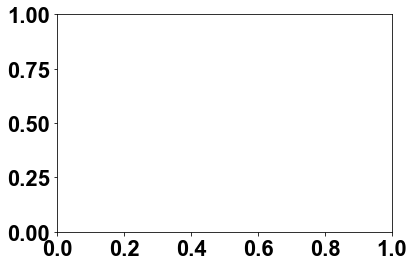

In [128]:
i=1
fig, ax = plt.subplots()
for year, row in df.iterrows(): 
    if year%2 != 1:
        continue
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    row['y'] = y
    res = [j - i for i, j in zip(y[: -1], y[i :])]
    i = i+2
    ax.plot(x + year, row['area']*res, label=year)
ax.legend(frameon=False, title='year installed')
ax.set_ylabel('area disposed / m^2')
pass


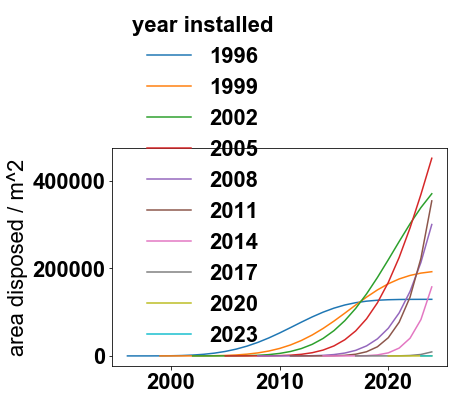

## Waste calculations

### Mass of waste ingredients

In [ ]:
for waste_ingredient in ['glass', 'silver']:
    df[f'waste_{waste_ingredient}'] = 0
    for year, row in df.iterrows():
        df[f'waste_{waste_ingredient}'] += row[f'mass_{waste_ingredient}']*row['disposal_function'](np.clip(df.index - year, 0, np.inf))

In [138]:
for waste_ingredient in ['glass', 'silver']:
    df[f'waste_{waste_ingredient}'] = 0
    for year, row in df.iterrows():
        df[f'waste_{waste_ingredient}'] += row[f'mass_{waste_ingredient}']*row['disposal_function'](np.clip(df.index - year, 0, np.inf))

In [ ]:
for waste_ingredient in ['glass', 'silver']:
    df[f'waste_{waste_ingredient}'] = 0
    for year, row in df.iterrows():
        df[f'waste_{waste_ingredient}'] += row[f'mass_{waste_ingredient}']*row['disposal_function'](np.clip(df.index - year, 0, np.inf))

In [ ]:
# if I did the math right, this isn't cumulative waste, it's each individual year's waste
fig, axa = plt.subplots(nrows=2)
for index, waste_ingredient in enumerate(['glass', 'silver']):
    ax = axa[index]
    ax.scatter(df.index, df[f'waste_{waste_ingredient}'], label=waste_ingredient)
    ax.set_ylabel(f'{waste_ingredient} waste / kg')
pass

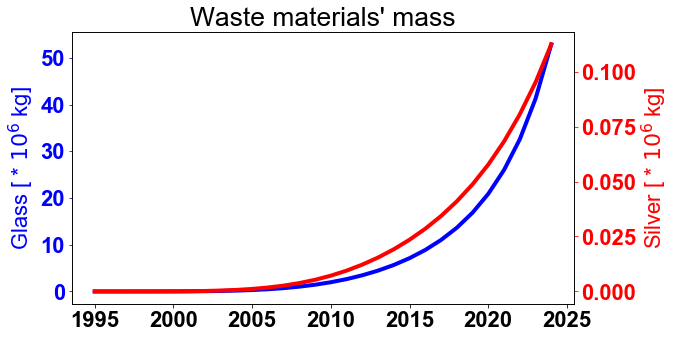

In [139]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['waste_glass']/1000000, 'blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass [ * $10^6$ kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2=ax.twinx()
plt.title("Waste materials' mass")
ax2.plot(df.index, df['waste_silver']/1000000, 'red', label='silver', linewidth=4)
ax2.set_ylabel('Silver [ * $10^6$ kg]', color='red')
ax2.tick_params(axis='y', colors='red')
pass


## Installed Capacity

Installed Capacity for each year is the Existing Installations + New Installations - Decommisionings 

In [ ]:
'''
for installedCapacity_ingredient in ['glass', 'silver']:
    df[f'installedCapacity_{installedCapacity_ingredient}'] = 0.0
    df[f'installedCapacity_{installedCapacity_ingredient}'][df.index[0]] =  df[f'mass_{installedCapacity_ingredient}'][df.index[0]] - df[f'waste_{waste_ingredient}'][df.index[0]]
    for i in range (1, len(df)):
        year = df.index[i]
        prevyear = df.index[i-1]
        df[f'installedCapacity_{installedCapacity_ingredient}'][year] = df[f'installedCapacity_{installedCapacity_ingredient}'][prevyear]+df[f'mass_{installedCapacity_ingredient}'][year] - df[f'waste_{waste_ingredient}'][year]

'''

In [ ]:
df['installedCapacity_glass'] = 0.0
df['installedCapacity_glass'][df.index[0]] =  df[f'mass_glass'][df.index[0]] - df[f'waste_glass'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = df.index[i-1]
    df[f'installedCapacity_glass'][year] = (df[f'installedCapacity_glass'][prevyear]+
                                           df[f'mass_glass'][year] - df['waste_glass'][year])
    
df['installedCapacity_silver'] = 0.0
df['installedCapacity_silver'][df.index[0]] =  df[f'mass_silver'][df.index[0]] - df[f'waste_silver'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = df.index[i-1]
    df[f'installedCapacity_silver'][year] = (df[f'installedCapacity_silver'][prevyear]+
                                           df[f'mass_silver'][year] - df['waste_silver'][year])

In [ ]:
# if I did the math right, this isn't cumulative waste, it's each individual year's waste
fig, axa = plt.subplots(nrows=2)
for index, installedCapacity_ingredient in enumerate(['glass', 'silver']):
    ax = axa[index]
    ax.scatter(df.index, df[f'installedCapacity_{installedCapacity_ingredient}'], label=installedCapacity_ingredient)
    ax.set_ylabel(f'{installedCapacity_ingredient} waste / kg')
pass

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['installedCapacity_glass']/1000000, 'blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass [ * $10^6$ kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2=ax.twinx()
plt.title("Installed Capacity")
ax2.plot(df.index, df['installedCapacity_silver']/1000000, 'red', label='silver', linewidth=4)
ax2.set_ylabel('Silver [ * $10^6$ kg]', color='red')
ax2.tick_params(axis='y', colors='red')
pass


In [ ]:
df[f'installedCapacity_{installedCapacity_ingredient}'] = 0
df[f'installedCapacity_{installedCapacity_ingredient}'][df.index[0]] =  df[f'mass_{installedCapacity_ingredient}'][df.index[0]] - df[f'waste_{waste_ingredient}'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = year = df.index[i-1]
    df[f'installedCapacity_{installedCapacity_ingredient}'][year] = df[f'installedCapacity_{installedCapacity_ingredient}'][prevyear]+df[f'mass_{installedCapacity_ingredient}'][year] - df[f'waste_{waste_ingredient}'][year]

## Waste from Feedstock

In development

In [ ]:
df['efficiency_manufacturing_glass'] = []   # in %
df['efficiency_manufacturing_silver'] = []  # in %

for ingredient in ['glass', 'silver']:
    df[f'feedstock_waste_{ingredient}'] = df[f'mass_{installedCapacity_ingredient}'][year]*(100-df['efficiency_manufacturing_glass'])/100
    df[f'feedstock_mass_{ingredient}'] = df[f'mass_{installedCapacity_ingredient}'][year]*100/df['efficiency_manufacturing_glass'])


## Waste from Recycling
Also in development

In [ ]:
df['Wc_Waste_recicled_silver'] = []  # in %
df['Wc_Waste_recicled_glass'] = []  # in %

df['efficiency_recyling_silver'] = []  # in %
df['efficiency_recyling_glass'] = []  # in %

for ingredient in ['glass', 'silver']:
    df[f'recycled_{ingredient}'] = df[f'waste_{ingredient}']*df[f'percentage_waste_recicled_{ingredient}']/100
    df[f'recyling_waste_{ingredient}'] = df[f'recycled_{ingredient}'] * 100 / df['efficiency_recyling_{ingredient}']  
    
    
    (100-df['efficiency_manufacturing_glass'])/100
    df[f'waste_waste_{ingredient}'] =  df[f'waste_{ingredient}']-df[f'recycled_{ingredient}'] _ 
